In [11]:
import numpy as np
import pandas as pd
import json 
import geocoder
from pandas.io.json import json_normalize 

from geopy.geocoders import Nominatim 

import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans

import folium 

In [12]:
df=pd.read_csv('istanbul.csv')
df.head()

postalcode      borough    dIstrIct
0       34010  ZEYTINBURNU     TOPKAPI
1       34015  ZEYTINBURNU  SEYITNIZAM
2       34020  ZEYTINBURNU      TELSIZ
3       34022     BESIKTAS    ABBASAGA
4       34025  ZEYTINBURNU     CIRPICI

In [13]:
def get_lat_lon(postal_code):
    lat_lon_coords = None
    while(lat_lon_coords is None):
        g = geocoder.arcgis('{}, Istanbul, Turkey'.format(postal_code))
        lat_lon_coords = g.latlng
    return lat_lon_coords

In [14]:
postal_codes = df['postalcode']    
coords = [get_lat_lon(postal_code) for postal_code in postal_codes.tolist()]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

df.head(20)

postalcode      borough      dIstrIct   Latitude  Longitude
0        34010  ZEYTINBURNU       TOPKAPI  41.019560  28.911448
1        34015  ZEYTINBURNU    SEYITNIZAM  41.010765  28.911920
2        34020  ZEYTINBURNU        TELSIZ  40.992104  28.905205
3        34022     BESIKTAS      ABBASAGA  41.046519  29.006215
4        34025  ZEYTINBURNU       CIRPICI  40.992650  28.897785
5        34030   BAYRAMPASA     NUMUNEBAG  41.039963  28.913460
6        34035   BAYRAMPASA    ALTINTEPSI  41.036630  28.898121
7        34040   BAYRAMPASA     MURATPASA  41.050654  28.902860
8        34045   BAYRAMPASA      YILDIRIM  41.057928  28.890880
9        34050   EYUPSULTAN          EYUP  41.044327  28.934055
10       34055   EYUPSULTAN          RAMI  41.040310  28.923555
11       34060   EYUPSULTAN     ALIBEYKOY  41.090525  28.950779
12       34065   EYUPSULTAN    YESILPINAR  41.074110  28.931962
13       34070   EYUPSULTAN        CIRCIR  41.085320  28.928972
14       34075   EYUPSULTAN   KEMERBURGAZ  41.164900  28.932190
15       34076   EYUPSULTAN       ISIKLAR  41.251974  28.859945
16       34077   EYUPSULTAN       GOKTURK  41.186126  28.876790
17       34080        FATIH  ISKENDERPASA  41.015735  28.947475
18       34083        FATIH        ZEYREK  41.022840  28.954061
19       34087        FATIH         BALAT  41.031573  28.944460

In [15]:
# import as csv
df.to_csv('istanbul_w_lat_lon.csv', index=False)

In [3]:
address = 'Istanbul, TURKEY'

geolocator = Nominatim(user_agent="Istanbul")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Istanbul are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Istanbul are 41.0096334, 28.9651646.


In [18]:
map_istanbul = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, dIstrIct in zip(df['Latitude'], df['Longitude'], df['borough'], df['dIstrIct']):
    label = '{}, {}'.format(dIstrIct, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_istanbul)  
    
map_istanbul

In [30]:
CLIENT_ID = 'AECK5FXJOXF3NRZXUIJAHSKRB1BR1MTWPYOYXP2BLGSOWYGV' # your Foursquare ID
CLIENT_SECRET = '3RICDETL0FRPMIWESWWNYGBNF25GQJXY4CZ21T4F50SODQCE' # your Foursquare Secret
VERSION = '20191201' # Foursquare API version, especially from 2019 :)

# c: AECK5FXJOXF3NRZXUIJAHSKRB1BR1MTWPYOYXP2BLGSOWYGV
# s: 3RICDETL0FRPMIWESWWNYGBNF25GQJXY4CZ21T4F50SODQCE

# c: NF1ZZVUYVSTRCUMVEDXOXELTM1RJ2SNOAY1B1N4N0L5UTSPY
# s: VS413IRNBYSG2SGNCPSVXWDFWTPGD452GIA44LMZKAGRPZLY

In [64]:
import requests

radius=500
LIMIT=100

def getNearbyVenues(postalcodes, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for pk, name, lat, lng in zip(postalcodes, names, latitudes, longitudes):
        print(pk, name)
            

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            

        results = requests.get(url).json()["response"]['groups'][0]['items']
        

        venues_list.append([(
            pk,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode','District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [66]:
istanbul_venues = getNearbyVenues(postalcodes=df['postalcode'],
                                   names=df['dIstrIct'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

34010 TOPKAPI
34015 SEYITNIZAM
34020 TELSIZ
34022 ABBASAGA
34025 CIRPICI
34030 NUMUNEBAG
34035 ALTINTEPSI
34040 MURATPASA
34045 YILDIRIM
34050 EYUP
34055 RAMI
34060 ALIBEYKOY
34065 YESILPINAR
34070 CIRCIR
34075 KEMERBURGAZ
34076 ISIKLAR
34077 GOKTURK
34080 ISKENDERPASA
34083 ZEYREK
34087 BALAT
34091 KARAGUMRUK
34093 TOPKAPI
34096 AKSARAY
34098 KOCAMUSTAFAPASA
34104 SEHREMINI
34107 YEDIKULE
34110 EMINONU
34112 SIRKECI
34116 TAHTAKALE
34120 MAHMUTPASA
34122 SULTANAHMET
34126 BAYAZIT
34130 KUMKAPI
34134 VEFA
34140 ZEYTINLIK
34142 CEVIZLIK
34145 KARTALTEPE
34146 OSMANIYE
34147 ZUHURATBABA
34149 YESILKOY
34153 FLORYA
34158 ATAKOY
34160 AKINCILAR
34164 GUNGOREN
34165 SANAYI
34173 TOZKOPARAN
34180 BAHCELIEVLER
34188 SIRINEVLER
34197 YENIBOSNA
34200 BAGCILAR
34212 GUNESLI
34218 MAHMUTBEY
34220 ESENLER
34225 KARABAYIR
34230 ATISALANI
34235 SANAYI
34240 YILDIZTABYA
34245 GAZIOSMANPASA
34250 KUCUKKOY
34255 MEVLANA
34260 ZUBEYDEHANIM
34265 SULTANCIFTLIGI
34270 SULTANGAZI
34275 ARNAVUTKOY
34277 BAK

In [67]:
istanbul_venues.head(10)

PostalCode District  District Latitude  District Longitude  \
0       34010  TOPKAPI           41.01956           28.911448   
1       34010  TOPKAPI           41.01956           28.911448   
2       34010  TOPKAPI           41.01956           28.911448   
3       34010  TOPKAPI           41.01956           28.911448   
4       34010  TOPKAPI           41.01956           28.911448   
5       34010  TOPKAPI           41.01956           28.911448   
6       34010  TOPKAPI           41.01956           28.911448   
7       34010  TOPKAPI           41.01956           28.911448   
8       34010  TOPKAPI           41.01956           28.911448   
9       34010  TOPKAPI           41.01956           28.911448   

                            Venue  Venue Latitude  Venue Longitude  \
0               Selanik Kahvecisi       41.018032        28.912180   
1                      Mucco Cafe       41.019773        28.911514   
2                  Game of Burger       41.017291        28.911139   
3          Kadayıfzade Cevizlibağ       41.018552        28.910799   
4                       Starbucks       41.018141        28.911913   
5     Club House (Fitness Center)       41.018929        28.910504   
6                          Haggar       41.018320        28.912249   
7     Hill's Coffee & Food Studio       41.018823        28.910631   
8  Vefa Turkcell Iletisim Merkezi       41.021079        28.913915   
9                       Starbucks       41.018341        28.911968   

         Venue Category  
0           Coffee Shop  
1                  Café  
2          Burger Joint  
3             Cafeteria  
4           Coffee Shop  
5  Gym / Fitness Center  
6            Restaurant  
7            Food Court  
8     Mobile Phone Shop  
9           Coffee Shop

In [68]:
istanbul_venues.shape

(10547, 8)

In [69]:
print('There are {} unique categories in Istanbul.'.format(len(istanbul_venues['Venue Category'].unique())))

There are 440 unique categories in Istanbul.


In [123]:
istanbul_venues['Venue Category'].value_counts()

Café                    1292
Turkish Restaurant       475
Restaurant               419
Coffee Shop              370
Bakery                   304
                        ... 
Non-Profit                 1
Volleyball Court           1
Caribbean Restaurant       1
Pet Service                1
Vineyard                   1
Name: Venue Category, Length: 440, dtype: int64

In [125]:
istanbul_venues_red=istanbul_venues.groupby('Venue Category').filter(lambda x : len(x)>20)
istanbul_venues_red['Venue Category'].value_counts()

Café                  1292
Turkish Restaurant     475
Restaurant             419
Coffee Shop            370
Bakery                 304
                      ... 
Wings Joint             22
Food Truck              21
Salon / Barbershop      21
Pet Store               21
Shoe Store              21
Name: Venue Category, Length: 98, dtype: int64

In [126]:
istanbul_onehot = pd.get_dummies(istanbul_venues_red[['Venue Category']], prefix="", prefix_sep="")

istanbul_onehot['PostalCode'] = istanbul_venues_red['PostalCode'] 
istanbul_onehot['District'] = istanbul_venues_red['District'] 

fixed_columns = [istanbul_onehot.columns[-1]] + list(istanbul_onehot.columns[:-1])
istanbul_onehot = istanbul_onehot[fixed_columns]

istanbul_onehot.head(10)

District  Arcade  Art Gallery  Arts & Crafts Store  Athletics & Sports  \
0   TOPKAPI       0            0                    0                   0   
1   TOPKAPI       0            0                    0                   0   
2   TOPKAPI       0            0                    0                   0   
4   TOPKAPI       0            0                    0                   0   
5   TOPKAPI       0            0                    0                   0   
6   TOPKAPI       0            0                    0                   0   
7   TOPKAPI       0            0                    0                   0   
8   TOPKAPI       0            0                    0                   0   
9   TOPKAPI       0            0                    0                   0   
10  TOPKAPI       0            0                    0                   0   

    Auto Garage  BBQ Joint  Bagel Shop  Bakery  Bar  ...  Steakhouse  \
0             0          0           0       0    0  ...           0   
1             0          0           0       0    0  ...           0   
2             0          0           0       0    0  ...           0   
4             0          0           0       0    0  ...           0   
5             0          0           0       0    0  ...           0   
6             0          0           0       0    0  ...           0   
7             0          0           0       0    0  ...           0   
8             0          0           0       0    0  ...           0   
9             0          0           0       0    0  ...           0   
10            0          0           0       0    0  ...           0   

    Supermarket  Tea Room  Theater  Turkish Home Cooking Restaurant  \
0             0         0        0                                0   
1             0         0        0                                0   
2             0         0        0                                0   
4             0         0        0                                0   
5             0         0        0                                0   
6             0         0        0                                0   
7             0         0        0                                0   
8             0         0        0                                0   
9             0         0        0                                0   
10            0         0        0                                0   

    Turkish Restaurant  Wings Joint  Women's Store  Yoga Studio  PostalCode  
0                    0            0              0            0       34010  
1                    0            0              0            0       34010  
2                    0            0              0            0       34010  
4                    0            0              0            0       34010  
5                    0            0              0            0       34010  
6                    0            0              0            0       34010  
7                    0            0              0            0       34010  
8                    0            0              0            0       34010  
9                    0            0              0            0       34010  
10                   0            0              0            0       34010  

[10 rows x 100 columns]

In [164]:
istanbul_grouped = istanbul_onehot.groupby('PostalCode').sum().reset_index()
istanbul_grouped.head(10)

PostalCode  Arcade  Art Gallery  Arts & Crafts Store  Athletics & Sports  \
0       34010       0            0                    0                   0   
1       34015       0            0                    0                   1   
2       34020       1            0                    2                   0   
3       34022       0            0                    0                   0   
4       34025       0            0                    1                   0   
5       34030       1            0                    1                   1   
6       34035       0            0                    0                   0   
7       34040       1            0                    1                   0   
8       34045       0            0                    0                   0   
9       34050       1            0                    0                   0   

   Auto Garage  BBQ Joint  Bagel Shop  Bakery  Bar  ...  Sports Club  \
0            0          0           0       0    0  ...            0   
1            0          0           0       1    0  ...            0   
2            0          0           0       2    0  ...            1   
3            0          1           0       2    7  ...            0   
4            0          0           1       1    0  ...            0   
5            0          0           1       0    0  ...            0   
6            0          1           0       4    0  ...            0   
7            0          0           2       1    0  ...            0   
8            1          0           0       1    0  ...            0   
9            0          0           0       1    0  ...            0   

   Steakhouse  Supermarket  Tea Room  Theater  \
0           1            0         0        0   
1           0            0         0        0   
2           1            0         2        1   
3           0            0         0        1   
4           1            0         2        0   
5           1            0         0        1   
6           2            0         0        0   
7           0            0         0        0   
8           4            0         0        0   
9           1            0         2        0   

   Turkish Home Cooking Restaurant  Turkish Restaurant  Wings Joint  \
0                                0                   2            0   
1                                1                   2            0   
2                                0                   4            0   
3                                0                   3            0   
4                                0                   2            0   
5                                0                   3            1   
6                                0                   7            0   
7                                0                   2            0   
8                                0                   1            0   
9                                0                   3            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            1  
4              0            0  
5              0            0  
6              0            0  
7              2            0  
8              0            0  
9              0            0  

[10 rows x 99 columns]

In [131]:
istanbul_grouped.shape

(251, 99)

In [165]:
num_top_venues = 5
for postalcode in istanbul_grouped['PostalCode']:
    print("----",postalcode,"----")
    temp = istanbul_grouped[istanbul_grouped['PostalCode'] == postalcode].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- 34010 ----
                     venue  freq
0              Coffee Shop   6.0
1             Dessert Shop   4.0
2  Comfort Food Restaurant   3.0
3                     Café   3.0
4       Turkish Restaurant   2.0


---- 34015 ----
                venue  freq
0                Café  11.0
1          Restaurant   3.0
2    Kebab Restaurant   2.0
3  Turkish Restaurant   2.0
4          Food Court   2.0


---- 34020 ----
                  venue  freq
0           Men's Store   5.0
1      Department Store   4.0
2    Turkish Restaurant   4.0
3  Gym / Fitness Center   4.0
4            Restaurant   3.0


---- 34022 ----
            venue  freq
0     Coffee Shop  19.0
1            Café  10.0
2             Pub   8.0
3             Bar   7.0
4  Chocolate Shop   4.0


---- 34025 ----
                venue  freq
0                Café   8.0
1          Restaurant   6.0
2        Dessert Shop   3.0
3         Men's Store   2.0
4  Turkish Restaurant   2.0


---- 34030 ----
                venue  freq
0       

In [166]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [167]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['PostalCode'] = istanbul_grouped['PostalCode']

for ind in np.arange(istanbul_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted.shape

(251, 11)

In [168]:
district_venues_sorted.head(10)

PostalCode 1st Most Common Venue 2nd Most Common Venue  \
0       34010           Coffee Shop          Dessert Shop   
1       34015                  Café            Restaurant   
2       34020           Men's Store  Gym / Fitness Center   
3       34022           Coffee Shop                  Café   
4       34025                  Café            Restaurant   
5       34030                  Café                 Hotel   
6       34035    Turkish Restaurant                  Park   
7       34040     Convenience Store    Turkish Restaurant   
8       34045            Hookah Bar            Steakhouse   
9       34050                  Café    Turkish Restaurant   

  3rd Most Common Venue    4th Most Common Venue   5th Most Common Venue  \
0                  Café  Comfort Food Restaurant  Furniture / Home Store   
1    Turkish Restaurant         Kebab Restaurant              Food Court   
2    Turkish Restaurant         Department Store              Restaurant   
3                   Pub                      Bar          Chocolate Shop   
4          Dessert Shop                 Tea Room             Men's Store   
5    Turkish Restaurant               Soup Place             Music Venue   
6                Bakery                    Hotel          Ice Cream Shop   
7  Gym / Fitness Center            Women's Store                    Café   
8                  Café         Kebab Restaurant              Restaurant   
9          Dessert Shop                    Hotel          Breakfast Spot   

    6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0      Turkish Restaurant            Pastry Shop            Food Court   
1            Soccer Field           Burger Joint          Dance Studio   
2            Dessert Shop               Tea Room        Clothing Store   
3            Burger Joint  Performing Arts Venue        Breakfast Spot   
4    Gym / Fitness Center     Turkish Restaurant        Clothing Store   
5             Men's Store            Beer Garden  Gym / Fitness Center   
6              Restaurant           Dessert Shop           Bus Station   
7              Bagel Shop            Kofte Place           Music Venue   
8  Furniture / Home Store             Food Court           Kofte Place   
9                Tea Room                 Mosque         Historic Site   

  9th Most Common Venue 10th Most Common Venue  
0            Restaurant       Department Store  
1                   Gym      Mobile Phone Shop  
2           Coffee Shop                 Bakery  
3            Restaurant           Dessert Shop  
4         Big Box Store            Music Venue  
5                  Park           Dessert Shop  
6        Soccer Stadium             Soup Place  
7              Pie Shop                  Diner  
8          Dessert Shop                   Park  
9         Jewelry Store                   Park

In [187]:
from sklearn.preprocessing import StandardScaler

istanbul_grouped_clustering = istanbul_grouped.drop('PostalCode', 1)


# Standarize features
scaler = StandardScaler()
istanbul_grouped_clustering_std = scaler.fit_transform(istanbul_grouped_clustering)

Sum_of_squared_distances = []

K = range(1,25)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(istanbul_grouped_clustering_std)
    Sum_of_squared_distances.append(km.inertia_)
    

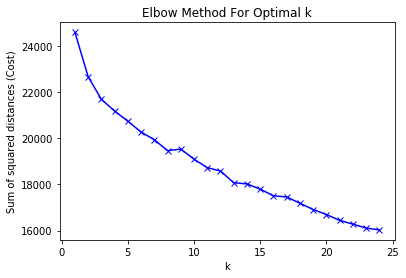

In [188]:
import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances (Cost)')
plt.title('Elbow Method For Optimal k')
plt.show()

In [194]:
kclusters = 8

kmeans = KMeans(n_clusters=kclusters, random_state=1234).fit(istanbul_grouped_clustering)

In [195]:
#district_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)
district_venues_sorted['Cluster_Labels']=kmeans.labels_
district_venues_sorted.head(10)

PostalCode 1st Most Common Venue 2nd Most Common Venue  \
0       34010           Coffee Shop          Dessert Shop   
1       34015                  Café            Restaurant   
2       34020           Men's Store  Gym / Fitness Center   
3       34022           Coffee Shop                  Café   
4       34025                  Café            Restaurant   
5       34030                  Café                 Hotel   
6       34035    Turkish Restaurant                  Park   
7       34040     Convenience Store    Turkish Restaurant   
8       34045            Hookah Bar            Steakhouse   
9       34050                  Café    Turkish Restaurant   

  3rd Most Common Venue    4th Most Common Venue   5th Most Common Venue  \
0                  Café  Comfort Food Restaurant  Furniture / Home Store   
1    Turkish Restaurant         Kebab Restaurant              Food Court   
2    Turkish Restaurant         Department Store              Restaurant   
3                   Pub                      Bar          Chocolate Shop   
4          Dessert Shop                 Tea Room             Men's Store   
5    Turkish Restaurant               Soup Place             Music Venue   
6                Bakery                    Hotel          Ice Cream Shop   
7  Gym / Fitness Center            Women's Store                    Café   
8                  Café         Kebab Restaurant              Restaurant   
9          Dessert Shop                    Hotel          Breakfast Spot   

    6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0      Turkish Restaurant            Pastry Shop            Food Court   
1            Soccer Field           Burger Joint          Dance Studio   
2            Dessert Shop               Tea Room        Clothing Store   
3            Burger Joint  Performing Arts Venue        Breakfast Spot   
4    Gym / Fitness Center     Turkish Restaurant        Clothing Store   
5             Men's Store            Beer Garden  Gym / Fitness Center   
6              Restaurant           Dessert Shop           Bus Station   
7              Bagel Shop            Kofte Place           Music Venue   
8  Furniture / Home Store             Food Court           Kofte Place   
9                Tea Room                 Mosque         Historic Site   

  9th Most Common Venue 10th Most Common Venue  Cluster_Labels  
0            Restaurant       Department Store               4  
1                   Gym      Mobile Phone Shop               1  
2           Coffee Shop                 Bakery               5  
3            Restaurant           Dessert Shop               7  
4         Big Box Store            Music Venue               5  
5                  Park           Dessert Shop               1  
6        Soccer Stadium             Soup Place               4  
7              Pie Shop                  Diner               0  
8          Dessert Shop                   Park               4  
9         Jewelry Store                   Park               1

In [196]:
istanbul_merged_df = df

istanbul_merged_df = df.join(district_venues_sorted.set_index('PostalCode'), on='postalcode')

istanbul_merged_df.head() 

postalcode      borough    dIstrIct   Latitude  Longitude  \
0       34010  ZEYTINBURNU     TOPKAPI  41.019560  28.911448   
1       34015  ZEYTINBURNU  SEYITNIZAM  41.010765  28.911920   
2       34020  ZEYTINBURNU      TELSIZ  40.992104  28.905205   
3       34022     BESIKTAS    ABBASAGA  41.046519  29.006215   
4       34025  ZEYTINBURNU     CIRPICI  40.992650  28.897785   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0           Coffee Shop          Dessert Shop                  Café   
1                  Café            Restaurant    Turkish Restaurant   
2           Men's Store  Gym / Fitness Center    Turkish Restaurant   
3           Coffee Shop                  Café                   Pub   
4                  Café            Restaurant          Dessert Shop   

     4th Most Common Venue   5th Most Common Venue 6th Most Common Venue  \
0  Comfort Food Restaurant  Furniture / Home Store    Turkish Restaurant   
1         Kebab Restaurant              Food Court          Soccer Field   
2         Department Store              Restaurant          Dessert Shop   
3                      Bar          Chocolate Shop          Burger Joint   
4                 Tea Room             Men's Store  Gym / Fitness Center   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Pastry Shop            Food Court            Restaurant   
1           Burger Joint          Dance Studio                   Gym   
2               Tea Room        Clothing Store           Coffee Shop   
3  Performing Arts Venue        Breakfast Spot            Restaurant   
4     Turkish Restaurant        Clothing Store         Big Box Store   

  10th Most Common Venue  Cluster_Labels  
0       Department Store             4.0  
1      Mobile Phone Shop             1.0  
2                 Bakery             5.0  
3           Dessert Shop             7.0  
4            Music Venue             5.0

In [197]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(istanbul_merged_df['Latitude'], istanbul_merged_df['Longitude'], istanbul_merged_df['dIstrIct'],kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [198]:
istanbul_merged_df['Cluster_Labels'].value_counts()

0.0    96
4.0    64
1.0    28
5.0    21
6.0    15
3.0    10
7.0     9
2.0     8
Name: Cluster_Labels, dtype: int64

In [319]:

istanbul_merged_df.loc[istanbul_merged_df['Cluster_Labels'] == 1, istanbul_merged_df.columns[[0,2] + list(range(5, istanbul_merged_df.shape[1]))]]

postalcode          dIstrIct 1st Most Common Venue 2nd Most Common Venue  \
1         34015        SEYITNIZAM                  Café            Restaurant   
5         34030         NUMUNEBAG                  Café                 Hotel   
9         34050              EYUP                  Café    Turkish Restaurant   
13        34070            CIRCIR                  Café     Convenience Store   
49        34200          BAGCILAR                  Café                   Gym   
51        34218         MAHMUTBEY                  Café            Hookah Bar   
52        34220           ESENLER                  Café                   Gym   
71        34303           HALKALI                  Café  Fast Food Restaurant   
72        34307           ATAKENT                  Café                  Pool   
75        34320         GUMUSPALA                  Café    Athletics & Sports   
78        34335           AKATLAR                  Café           Coffee Shop   
79        34337            ETILER                  Café           Coffee Shop   
81        34342             BEBEK                  Café            Restaurant   
91        34375           BOZKURT                  Café           Coffee Shop   
92        34377           FERIKOY                  Café           Coffee Shop   
100       34406  KAGITHANE MERKEZ                  Café    Turkish Restaurant   
159       34674         KUZGUNCUK                  Café            Restaurant   
168       34697        CUMHURIYET                  Café    Turkish Restaurant   
169       34700            UNALAN                  Café                   Gym   
170       34704             ORNEK                  Café                  Park   
177       34722            EGITIM       Motorcycle Shop                  Café   
182       34732       MERDIVENKOY                  Café                Bakery   
188       34744          BOSTANCI                  Café                Bakery   
192       34755         KAYISDAGI                  Café  Fast Food Restaurant   
220       34841         IDEALTEPE    Seafood Restaurant                  Café   
221       34843         FEYZULLAH                  Café                Bakery   
234       34880          SOGANLIK                  Café            Steakhouse   
239       34890             CARSI                  Café                 Hotel   

    3rd Most Common Venue    4th Most Common Venue   5th Most Common Venue  \
1      Turkish Restaurant         Kebab Restaurant              Food Court   
5      Turkish Restaurant               Soup Place             Music Venue   
9            Dessert Shop                    Hotel          Breakfast Spot   
13   Gym / Fitness Center       Turkish Restaurant  Furniture / Home Store   
49            Coffee Shop             Dessert Shop                  Garden   
51       Kebab Restaurant           Soccer Stadium              Restaurant   
52   Gym / Fitness Center               Hookah Bar          Clothing Store   
71             Steakhouse              Pizza Place                  Arcade   
72             Restaurant                     Park                     Gym   
75                   Pool     Gym / Fitness Center                     Gym   
78   Gym / Fitness Center       Italian Restaurant        Kebab Restaurant   
79   Gym / Fitness Center               Restaurant             Pizza Place   
81                 Lounge              Coffee Shop              Steakhouse   
91       Kebab Restaurant                    Hotel                     Pub   
92       Kebab Restaurant       Turkish Restaurant           Grocery Store   
100          Soccer Field                    Plaza            Dessert Shop   
159    Turkish Restaurant           Chocolate Shop              Steakhouse   
168  Fast Food Restaurant                   Arcade           Grocery Store   
169      Kebab Restaurant                     Park               Nightclub   
170                Bakery               Restaurant       Convenience Store   
177    Turkish Re

In [216]:
myInput = [
            {'postalcode':34015, 'rating':4},
            {'postalcode':34744, 'rating':4},
            {'postalcode':34394, 'rating':5},
            {'postalcode':34728, 'rating':5},
            {'postalcode':34740, 'rating':4.5},
            {'postalcode':34060, 'rating':2},
            {'postalcode':34970, 'rating':3.5},
            {'postalcode':34055, 'rating':2},
            {'postalcode':34116, 'rating':1.5}
         ] 
myRatings = pd.DataFrame(myInput)

myRatings

postalcode  rating
0       34015     4.0
1       34744     4.0
2       34394     5.0
3       34728     5.0
4       34740     4.5
5       34060     2.0
6       34970     3.5
7       34055     2.0
8       34116     1.5

In [291]:
ratedDistrict = istanbul_grouped[istanbul_grouped['PostalCode'].isin(myRatings['postalcode'].tolist())]
ratedDistrict = ratedDistrict.reset_index(drop=True)

ratedDistrict

PostalCode  Arcade  Art Gallery  Arts & Crafts Store  Athletics & Sports  \
0       34015       0            0                    0                   1   
1       34055       0            0                    0                   0   
2       34060       0            0                    0                   0   
3       34116       0            1                    4                   0   
4       34394       0            0                    0                   0   
5       34728       0            0                    0                   0   
6       34740       0            2                    0                   0   
7       34744       0            0                    0                   1   
8       34970       0            0                    0                   0   

   Auto Garage  BBQ Joint  Bagel Shop  Bakery  Bar  ...  Sports Club  \
0            0          0           0       1    0  ...            0   
1            0          0           0       1    0  ...            0   
2            0          0           0       0    0  ...            0   
3            0          0           0       1    0  ...            0   
4            0          0           0       1    1  ...            0   
5            0          0           0       3    1  ...            0   
6            0          0           0       4    4  ...            1   
7            0          0           0       3    1  ...            0   
8            0          0           0       0    0  ...            0   

   Steakhouse  Supermarket  Tea Room  Theater  \
0           0            0         0        0   
1           0            0         0        0   
2           0            0         0        0   
3           1            0         3        0   
4           1            0         0        1   
5           1            1         2        0   
6           1            3         0        0   
7           0            0         0        0   
8           0            0         0        0   

   Turkish Home Cooking Restaurant  Turkish Restaurant  Wings Joint  \
0                                1                   2            0   
1                                0                   4            0   
2                                0                   0            0   
3                                0                   9            0   
4                                1                   1            0   
5                                0                   1            1   
6                                0                   1            0   
7                                0                   3            0   
8                                0                   0            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  
5              0            2  
6              0            1  
7              0            1  
8              0            0  

[9 rows x 99 columns]

In [292]:
ratedDistrict = ratedDistrict.drop('PostalCode',1)

ratedDistrict

Arcade  Art Gallery  Arts & Crafts Store  Athletics & Sports  Auto Garage  \
0       0            0                    0                   1            0   
1       0            0                    0                   0            0   
2       0            0                    0                   0            0   
3       0            1                    4                   0            0   
4       0            0                    0                   0            0   
5       0            0                    0                   0            0   
6       0            2                    0                   0            0   
7       0            0                    0                   1            0   
8       0            0                    0                   0            0   

   BBQ Joint  Bagel Shop  Bakery  Bar  Beer Garden  ...  Sports Club  \
0          0           0       1    0            0  ...            0   
1          0           0       1    0            0  ...            0   
2          0           0       0    0            0  ...            0   
3          0           0       1    0            0  ...            0   
4          0           0       1    1            0  ...            0   
5          0           0       3    1            0  ...            0   
6          0           0       4    4            0  ...            1   
7          0           0       3    1            0  ...            0   
8          0           0       0    0            0  ...            0   

   Steakhouse  Supermarket  Tea Room  Theater  \
0           0            0         0        0   
1           0            0         0        0   
2           0            0         0        0   
3           1            0         3        0   
4           1            0         0        1   
5           1            1         2        0   
6           1            3         0        0   
7           0            0         0        0   
8           0            0         0        0   

   Turkish Home Cooking Restaurant  Turkish Restaurant  Wings Joint  \
0                                1                   2            0   
1                                0                   4            0   
2                                0                   0            0   
3                                0                   9            0   
4                                1                   1            0   
5                                0                   1            1   
6                                0                   1            0   
7                                0                   3            0   
8                                0                   0            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  
5              0            2  
6              0            1  
7              0            1  
8              0            0  

[9 rows x 98 columns]

In [293]:
#Dot produt to get weights
myProfile = ratedDistrict.transpose().dot(myRatings['rating'])
#The user profile
myProfile

Arcade                              0.0
Art Gallery                        12.0
Arts & Crafts Store                20.0
Athletics & Sports                  6.0
Auto Garage                         0.0
                                   ... 
Turkish Home Cooking Restaurant     8.5
Turkish Restaurant                 85.0
Wings Joint                         2.0
Women's Store                       0.0
Yoga Studio                         9.5
Length: 98, dtype: float64

In [294]:
groupTable = istanbul_grouped.set_index(istanbul_grouped['PostalCode'])
groupTable = groupTable.drop('PostalCode', 1)
groupTable.head()



Arcade  Art Gallery  Arts & Crafts Store  Athletics & Sports  \
PostalCode                                                                 
34010            0            0                    0                   0   
34015            0            0                    0                   1   
34020            1            0                    2                   0   
34022            0            0                    0                   0   
34025            0            0                    1                   0   

            Auto Garage  BBQ Joint  Bagel Shop  Bakery  Bar  Beer Garden  ...  \
PostalCode                                                                ...   
34010                 0          0           0       0    0            0  ...   
34015                 0          0           0       1    0            0  ...   
34020                 0          0           0       2    0            1  ...   
34022                 0          1           0       2    7            1  ...   
34025                 0          0           1       1    0            1  ...   

            Sports Club  Steakhouse  Supermarket  Tea Room  Theater  \
PostalCode                                                            
34010                 0           1            0         0        0   
34015                 0           0            0         0        0   
34020                 1           1            0         2        1   
34022                 0           0            0         0        1   
34025                 0           1            0         2        0   

            Turkish Home Cooking Restaurant  Turkish Restaurant  Wings Joint  \
PostalCode                                                                     
34010                                     0                   2            0   
34015                                     1                   2            0   
34020                                     0                   4            0   
34022                                     0                   3            0   
34025                                     0                   2            0   

            Women's Store  Yoga Studio  
PostalCode                              
34010                   0            0  
34015                   0            0  
34020                   0            0  
34022                   0            1  
34025                   0            0  

[5 rows x 98 columns]

In [313]:
similarityTable_df = pd.DataFrame(((groupTable*myProfile).sum(axis=1))/(myProfile.sum()), columns=['similarity'])
similarityTable_df.head()

similarity
PostalCode            
34010         1.422448
34015         1.959751
34020         1.237565
34022         3.736584
34025         1.916230

In [314]:
#Sort our recommendations in descending order
similarityTable_df = similarityTable_df.sort_values(by=['similarity'], ascending=False)

#Just a peek at the values
similarityTable_df

similarity
PostalCode            
34710         5.297448
34714         4.632199
34672         4.436518
34315         4.211387
34421         4.153141
...                ...
34791         0.004254
34858         0.003927
34799         0.003927
34270         0.002618
34555         0.000000

[251 rows x 1 columns]

In [315]:
similarityTable_df = similarityTable_df.join(df.set_index('postalcode'), on='PostalCode')

similarityTable_df = similarityTable_df.join(district_venues_sorted.set_index('PostalCode'), on='PostalCode')

similarityTable_df = similarityTable_df[~similarityTable_df.index.isin(myRatings['postalcode'])]


In [316]:
similarityTable_df.head(10)

similarity   borough    dIstrIct   Latitude  Longitude  \
PostalCode                                                           
34710         5.297448   KADIKOY    CAFERAGA  40.986025  29.025368   
34714         4.632199   KADIKOY    OSMANAGA  40.989369  29.029490   
34672         4.436518   USKUDAR  MIMARSINAN  41.022190  29.015857   
34315         4.211387   AVCILAR     AMBARLI  40.975555  28.722715   
34421         4.153141   BEYOGLU    ARAPCAMI  41.025630  28.971715   
34134         4.034359     FATIH        VEFA  41.017593  28.961115   
34844         3.996728   MALTEPE        YALI  40.921310  29.131098   
34425         3.947317   BEYOGLU    KEMANKES  41.026645  28.978207   
34087         3.926374     FATIH       BALAT  41.031573  28.944460   
34357         3.793848  BESIKTAS     TURKALI  41.043954  28.998620   

           1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
PostalCode                                                                     
34710                       Café           Coffee Shop                   Bar   
34714                       Café           Coffee Shop                   Pub   
34672                       Café           Coffee Shop    Turkish Restaurant   
34315                       Café                   Pub           Coffee Shop   
34421                       Café            Restaurant           Coffee Shop   
34134                       Café    Turkish Restaurant            Restaurant   
34844                       Café    Turkish Restaurant          Dessert Shop   
34425                       Café           Coffee Shop            Restaurant   
34087                       Café           Coffee Shop    Turkish Restaurant   
34357                       Café           Coffee Shop        Breakfast Spot   

           4th Most Common Venue            5th Most Common Venue  \
PostalCode                                                          
34710                    Theater                      Art Gallery   
34714                        Bar                       Restaurant   
34672                        Gym  Turkish Home Cooking Restaurant   
34315                 Restaurant             Gym / Fitness Center   
34421                      Hotel               Turkish Restaurant   
34134                     Mosque                            Hotel   
34844                 Restaurant                              Pub   
34425                      Hotel                      Art Gallery   
34087                Art Gallery                           Bakery   
34357                     Lounge                            Hotel   

           6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
PostalCode                                                                     
34710                 Restaurant        Chocolate Shop        Breakfast Spot   
34714                    Theater           Pizza Place           Art Gallery   
34672                 Restaurant                Mosque  Gym / Fitness Center   
34315                     Bakery            Steakhouse               Meyhane   
34421              Historic Site          Cocktail Bar                   Bar   
34134                 Hookah Bar              Tea Room      Department Store   
34844                Coffee Shop               Meyhane                   Bar   
34425                      Plaza                   Bar         Historic Site   
34087                 Restaurant               Meyhane     Convenience Store   
34357             Chocolate Shop           Pizza Place                Bakery   

            9th Most Common Venue 10th Most Common Venue  Cluster_Labels  
PostalCode                                                                
34710                 Pizza Place     Seafood Restaurant               2  
34714       Performing Arts Venue         Cosmetics Shop               2  
34672                 Snack Place     Kokoreç Restaurant               2  
34315            Kebab Restaurant           D